<a href="https://colab.research.google.com/github/avbarbaros/gaussian-elimination/blob/main/gaussian_elimination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Gaussian Elimination with Partial Pivoting**

This notebook implements and analyzes Gaussian elimination with partial pivoting,
comparing it against NumPy's built-in solver and testing on ill-conditioned matrices.


In [1]:
# ============================================================================
# Part 1: Gaussian Elimination with Partial Pivoting Implementation
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import hilbert
import time

def gaussian_elimination_partial_pivoting(A, b, verbose=False):
    """
    Solve the linear system Ax = b using Gaussian elimination with partial pivoting.

    Algorithm Explanation:
    ----------------------
    Gaussian elimination transforms the augmented matrix [A|b] into upper triangular form
    through row operations, then solves via back substitution.

    Partial Pivoting Strategy:
    - At each elimination step k, find the row i >= k with maximum |a_ik|
    - Swap row k with row i to place the largest pivot element in position (k,k)
    - This improves numerical stability by minimizing roundoff errors

    Mathematical Foundation:
    - Without pivoting: small pivot elements cause large multipliers, amplifying errors
    - With pivoting: we maximize |a_kk| at each step, keeping multipliers |m_ik| <= 1
    - Growth factor: measures how much elements grow during elimination

    Parameters:
    -----------
    A : ndarray, shape (n, n)
        Coefficient matrix
    b : ndarray, shape (n,)
        Right-hand side vector
    verbose : bool
        If True, print intermediate steps

    Returns:
    --------
    x : ndarray, shape (n,)
        Solution vector
    A_upper : ndarray, shape (n, n)
        Upper triangular matrix after elimination
    steps : list
        Information about pivoting steps
    """
    n = len(b)
    # Create copies to avoid modifying original data
    A = A.astype(float).copy()
    b = b.astype(float).copy()

    steps = []

    # Forward elimination with partial pivoting
    for k in range(n-1):
        # Find the pivot: maximum absolute value in column k, from row k to n-1
        pivot_row = k + np.argmax(np.abs(A[k:n, k]))
        pivot_value = A[pivot_row, k]

        if verbose:
            print(f"\n--- Step {k+1} ---")
            print(f"Column {k}: Max pivot |{pivot_value:.6f}| at row {pivot_row}")

        # Check for singular matrix
        if np.abs(pivot_value) < 1e-14:
            raise ValueError(f"Matrix is singular or nearly singular at step {k}")

        # Swap rows if necessary (partial pivoting)
        if pivot_row != k:
            A[[k, pivot_row]] = A[[pivot_row, k]]
            b[[k, pivot_row]] = b[[pivot_row, k]]
            if verbose:
                print(f"Swapped row {k} with row {pivot_row}")

        steps.append({
            'step': k,
            'pivot_row': pivot_row,
            'pivot_value': pivot_value,
            'swapped': pivot_row != k
        })

        # Elimination: zero out elements below the pivot
        for i in range(k+1, n):
            # Compute multiplier: m_ik = a_ik / a_kk
            multiplier = A[i, k] / A[k, k]

            # Row operation: Row_i = Row_i - m_ik * Row_k
            A[i, k:n] -= multiplier * A[k, k:n]
            b[i] -= multiplier * b[k]

            # Explicitly zero out the eliminated element (numerical stability)
            A[i, k] = 0.0

            if verbose:
                print(f"  Eliminated A[{i},{k}] using multiplier {multiplier:.6f}")

    if verbose:
        print("\nUpper triangular matrix after elimination:")
        print(A)
        print(f"Modified b: {b}")

    # Back substitution
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        # x_i = (b_i - sum(a_ij * x_j for j > i)) / a_ii
        x[i] = (b[i] - np.dot(A[i, i+1:], x[i+1:])) / A[i, i]

    return x, A, steps


def analyze_pivoting_strategy(steps):
    """
    Analyze the pivoting behavior during Gaussian elimination.

    Parameters:
    -----------
    steps : list
        Pivoting information from gaussian_elimination_partial_pivoting

    Returns:
    --------
    dict : Analysis results including swap count, pivot ratios, etc.
    """
    n_steps = len(steps)
    n_swaps = sum(1 for s in steps if s['swapped'])
    pivot_values = [abs(s['pivot_value']) for s in steps]

    analysis = {
        'total_steps': n_steps,
        'number_of_swaps': n_swaps,
        'swap_percentage': 100 * n_swaps / n_steps if n_steps > 0 else 0,
        'min_pivot': min(pivot_values) if pivot_values else 0,
        'max_pivot': max(pivot_values) if pivot_values else 0,
        'mean_pivot': np.mean(pivot_values) if pivot_values else 0,
        'pivot_ratio': max(pivot_values) / min(pivot_values) if pivot_values and min(pivot_values) > 0 else np.inf
    }

    return analysis

print("\n Gaussian Elimination Example with Detailed Steps")
A1 = np.array([
    [2.0, 1.0, -1.0],
    [-3.0, -1.0, 2.0],
    [-2.0, 1.0, 2.0]
])
b1 = np.array([8.0, -11.0, -3.0])
print("\nMatrix A:")
print(A1)
print(f"Vector b: {b1}")

x1, A1_upper, steps2 = gaussian_elimination_partial_pivoting(A1, b1, verbose=True)
print(f"\nFinal solution: {x1}")
print(f"Verification Ax = {A1 @ x1}")
print(f"Expected b    = {b1}")


 Gaussian Elimination Example with Detailed Steps

Matrix A:
[[ 2.  1. -1.]
 [-3. -1.  2.]
 [-2.  1.  2.]]
Vector b: [  8. -11.  -3.]

--- Step 1 ---
Column 0: Max pivot |-3.000000| at row 1
Swapped row 0 with row 1
  Eliminated A[1,0] using multiplier -0.666667
  Eliminated A[2,0] using multiplier 0.666667

--- Step 2 ---
Column 1: Max pivot |1.666667| at row 2
Swapped row 1 with row 2
  Eliminated A[2,1] using multiplier 0.200000

Upper triangular matrix after elimination:
[[-3.         -1.          2.        ]
 [ 0.          1.66666667  0.66666667]
 [ 0.          0.          0.2       ]]
Modified b: [-11.           4.33333333  -0.2       ]

Final solution: [ 2.  3. -1.]
Verification Ax = [  8. -11.  -3.]
Expected b    = [  8. -11.  -3.]


In [2]:
# ============================================================================
# Part 2: Comparison with NumPy's Built-in Solver
# ============================================================================

def compare_solvers(A, b, name="Test Matrix"):
    """
    Compare custom Gaussian elimination with NumPy's solver.

    NumPy's np.linalg.solve uses LAPACK's DGESV routine, which employs
    LU decomposition with partial pivoting - essentially the same algorithm
    but with highly optimized BLAS operations.

    Parameters:
    -----------
    A : ndarray
        Coefficient matrix
    b : ndarray
        Right-hand side vector
    name : str
        Name of the test case

    Returns:
    --------
    dict : Comparison results
    """
    print(f"\n{'='*70}")
    print(f"Comparison: {name}")
    print(f"{'='*70}")

    # Custom implementation
    start_time = time.time()
    x_custom, A_upper, steps = gaussian_elimination_partial_pivoting(A, b)
    time_custom = time.time() - start_time

    # NumPy solver
    start_time = time.time()
    x_numpy = np.linalg.solve(A, b)
    time_numpy = time.time() - start_time

    # Compute residuals: ||Ax - b||
    residual_custom = np.linalg.norm(A @ x_custom - b)
    residual_numpy = np.linalg.norm(A @ x_numpy - b)

    # Solution difference
    solution_diff = np.linalg.norm(x_custom - x_numpy)

    # Pivoting analysis
    pivot_analysis = analyze_pivoting_strategy(steps)

    results = {
        'x_custom': x_custom,
        'x_numpy': x_numpy,
        'time_custom': time_custom,
        'time_numpy': time_numpy,
        'residual_custom': residual_custom,
        'residual_numpy': residual_numpy,
        'solution_diff': solution_diff,
        'pivot_analysis': pivot_analysis
    }

    # Print results
    print(f"\nSolution vectors:")
    print(f"Custom GE:  {x_custom}")
    print(f"NumPy:      {x_numpy}")

    print(f"\nPerformance:")
    print(f"Custom GE time:  {time_custom:.6f} seconds")
    print(f"NumPy time:      {time_numpy:.6f} seconds")
    print(f"Speedup factor:  {time_custom/time_numpy:.2f}x")

    print(f"\nAccuracy (Residuals ||Ax - b||):")
    print(f"Custom GE:  {residual_custom:.2e}")
    print(f"NumPy:      {residual_numpy:.2e}")

    print(f"\nSolution difference ||x_custom - x_numpy||: {solution_diff:.2e}")

    print(f"\nPivoting Analysis:")
    print(f"  Total elimination steps: {pivot_analysis['total_steps']}")
    print(f"  Number of row swaps:     {pivot_analysis['number_of_swaps']}")
    print(f"  Swap percentage:         {pivot_analysis['swap_percentage']:.1f}%")
    print(f"  Pivot value range:       [{pivot_analysis['min_pivot']:.2e}, {pivot_analysis['max_pivot']:.2e}]")
    print(f"  Pivot ratio (max/min):   {pivot_analysis['pivot_ratio']:.2e}")

    return results

print("\n Comparing Gaussian elimination with NumPy's solver with Well-Conditioned Random Matrix")
np.random.seed(42)
n = 5
A2 = np.random.randn(n, n)
b2 = np.random.randn(n)
results2 = compare_solvers(A2, b2, "Random 5×5 Matrix")



 Comparing Gaussian elimination with NumPy's solver with Well-Conditioned Random Matrix

Comparison: Random 5×5 Matrix

Solution vectors:
Custom GE:  [ 0.33950798  1.86215687 -2.9397798   1.01930545 -2.35479429]
NumPy:      [ 0.33950798  1.86215687 -2.9397798   1.01930545 -2.35479429]

Performance:
Custom GE time:  0.000658 seconds
NumPy time:      0.000496 seconds
Speedup factor:  1.33x

Accuracy (Residuals ||Ax - b||):
Custom GE:  1.29e-15
NumPy:      8.02e-16

Solution difference ||x_custom - x_numpy||: 2.64e-15

Pivoting Analysis:
  Total elimination steps: 4
  Number of row swaps:     3
  Swap percentage:         75.0%
  Pivot value range:       [8.95e-01, 3.41e+00]
  Pivot ratio (max/min):   3.81e+00




Hilbert Matrices

Testing on Hilbert Matrices (Ill-Conditioned)

--- Hilbert Matrix H_2 ---
Condition number κ(H_2):    1.93e+01
Relative error (Custom):     5.66e-16
Relative error (NumPy):      5.66e-16
Residual (Custom):           0.00e+00
Residual (NumPy):            0.00e+00

--- Hilbert Matrix H_3 ---
Condition number κ(H_3):    5.24e+02
Relative error (Custom):     8.03e-15
Relative error (NumPy):      8.02e-15
Residual (Custom):           2.48e-16
Residual (NumPy):            0.00e+00

--- Hilbert Matrix H_4 ---
Condition number κ(H_4):    1.55e+04
Relative error (Custom):     9.58e-14
Relative error (NumPy):      4.14e-14
Residual (Custom):           0.00e+00
Residual (NumPy):            0.00e+00

--- Hilbert Matrix H_5 ---
Condition number κ(H_5):    4.77e+05
Relative error (Custom):     3.49e-13
Relative error (NumPy):      1.68e-12
Residual (Custom):           5.21e-16
Residual (NumPy):            2.72e-16

--- Hilbert Matrix H_6 ---
Condition number κ(H_6):    1.50e+07
R

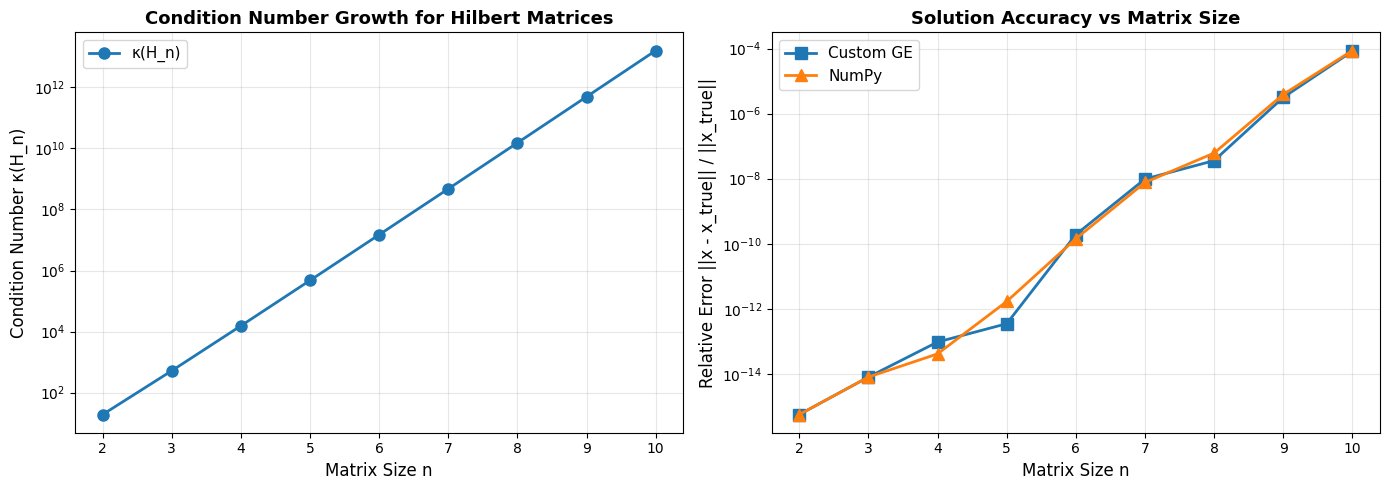

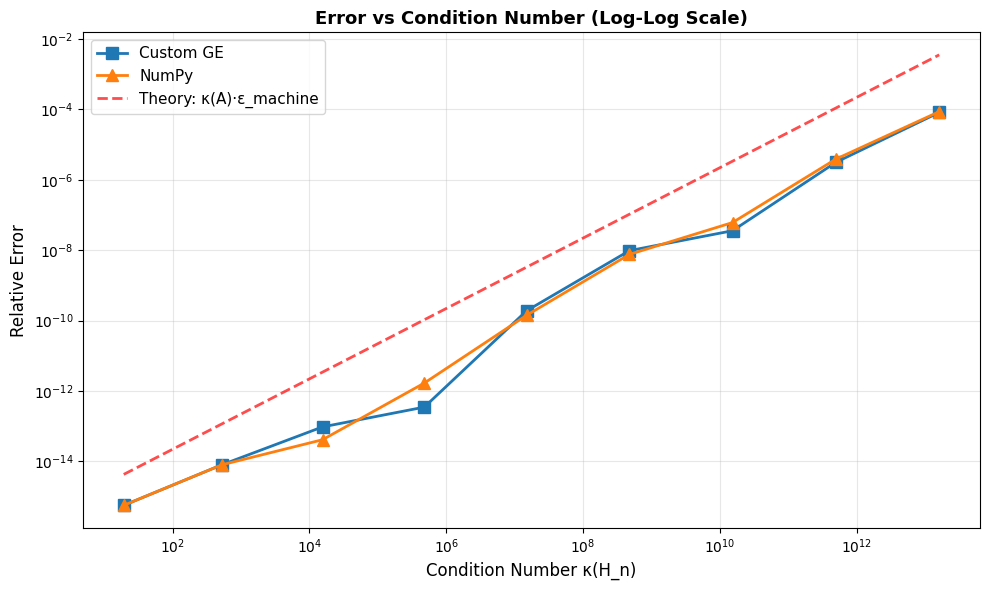

In [3]:
# ============================================================================
# Part 3: Testing on Ill-Conditioned Matrices (Hilbert Matrices)
# ============================================================================

def test_hilbert_matrices(max_n=10):
    """
    Test solvers on Hilbert matrices - notoriously ill-conditioned.

    Hilbert Matrix Definition:
    H_ij = 1 / (i + j - 1)  for i,j = 1, 2, ..., n

    Example (n=3):
    [1    1/2  1/3]
    [1/2  1/3  1/4]
    [1/3  1/4  1/5]

    Properties:
    - Symmetric and positive definite
    - Condition number grows exponentially: κ(H_n) ≈ exp(3.5n)
    - Small perturbations in b cause large changes in x
    - Classical test case for numerical stability

    Parameters:
    -----------
    max_n : int
        Maximum size of Hilbert matrix to test

    Returns:
    --------
    results : list of dict
        Test results for each matrix size
    """
    results = []

    print(f"\n{'='*70}")
    print(f"Testing on Hilbert Matrices (Ill-Conditioned)")
    print(f"{'='*70}")

    for n in range(2, max_n + 1):
        print(f"\n--- Hilbert Matrix H_{n} ---")

        # Generate Hilbert matrix
        H = hilbert(n)

        # Create a known solution and compute b = Hx
        x_true = np.ones(n)
        b = H @ x_true

        try:
            # Solve using both methods
            x_custom, _, _ = gaussian_elimination_partial_pivoting(H, b)
            x_numpy = np.linalg.solve(H, b)

            # Compute errors
            error_custom = np.linalg.norm(x_custom - x_true) / np.linalg.norm(x_true)
            error_numpy = np.linalg.norm(x_numpy - x_true) / np.linalg.norm(x_true)

            # Compute residuals
            residual_custom = np.linalg.norm(H @ x_custom - b)
            residual_numpy = np.linalg.norm(H @ x_numpy - b)

            # Condition number
            cond = np.linalg.cond(H)

            result = {
                'n': n,
                'condition_number': cond,
                'error_custom': error_custom,
                'error_numpy': error_numpy,
                'residual_custom': residual_custom,
                'residual_numpy': residual_numpy,
                'success': True
            }

            print(f"Condition number κ(H_{n}):    {cond:.2e}")
            print(f"Relative error (Custom):     {error_custom:.2e}")
            print(f"Relative error (NumPy):      {error_numpy:.2e}")
            print(f"Residual (Custom):           {residual_custom:.2e}")
            print(f"Residual (NumPy):            {residual_numpy:.2e}")

        except Exception as e:
            print(f"Failed to solve H_{n}: {str(e)}")
            result = {
                'n': n,
                'condition_number': np.linalg.cond(hilbert(n)),
                'error_custom': np.nan,
                'error_numpy': np.nan,
                'residual_custom': np.nan,
                'residual_numpy': np.nan,
                'success': False
            }

        results.append(result)

    return results


def visualize_hilbert_analysis(hilbert_results):
    """
    Create visualizations for Hilbert matrix analysis.

    Parameters:
    -----------
    hilbert_results : list
        Results from test_hilbert_matrices
    """
    # Extract data
    sizes = [r['n'] for r in hilbert_results if r['success']]
    conds = [r['condition_number'] for r in hilbert_results if r['success']]
    errors_custom = [r['error_custom'] for r in hilbert_results if r['success']]
    errors_numpy = [r['error_numpy'] for r in hilbert_results if r['success']]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Condition numbers
    axes[0].semilogy(sizes, conds, 'o-', linewidth=2, markersize=8, label='κ(H_n)')
    axes[0].set_xlabel('Matrix Size n', fontsize=12)
    axes[0].set_ylabel('Condition Number κ(H_n)', fontsize=12)
    axes[0].set_title('Condition Number Growth for Hilbert Matrices', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(fontsize=11)

    # Plot 2: Relative errors
    axes[1].semilogy(sizes, errors_custom, 's-', linewidth=2, markersize=8, label='Custom GE')
    axes[1].semilogy(sizes, errors_numpy, '^-', linewidth=2, markersize=8, label='NumPy')
    axes[1].set_xlabel('Matrix Size n', fontsize=12)
    axes[1].set_ylabel('Relative Error ||x - x_true|| / ||x_true||', fontsize=12)
    axes[1].set_title('Solution Accuracy vs Matrix Size', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(fontsize=11)

    plt.tight_layout()
    plt.show()

    # Additional plot: Error vs Condition Number
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.loglog(conds, errors_custom, 's-', linewidth=2, markersize=8, label='Custom GE')
    ax.loglog(conds, errors_numpy, '^-', linewidth=2, markersize=8, label='NumPy')

    # Theoretical bound: error ≈ κ(A) * machine_epsilon
    machine_eps = np.finfo(float).eps
    theoretical_bound = [c * machine_eps for c in conds]
    ax.loglog(conds, theoretical_bound, 'r--', linewidth=2, alpha=0.7, label=f'Theory: κ(A)·ε_machine')

    ax.set_xlabel('Condition Number κ(H_n)', fontsize=12)
    ax.set_ylabel('Relative Error', fontsize=12)
    ax.set_title('Error vs Condition Number (Log-Log Scale)', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.show()


print("\n\nHilbert Matrices")
hilbert_results = test_hilbert_matrices(max_n=10)
print("\n\nGenerating visualizations...")
visualize_hilbert_analysis(hilbert_results)

In [4]:
# ============================================================================
# Part 4: Condition Number Analysis
# ============================================================================

def compute_condition_numbers(matrix_types):
    """
    Compute and analyze condition numbers for various matrix types.

    Condition Number Definition:
    κ(A) = ||A|| · ||A^(-1)||

    For the 2-norm: κ(A) = σ_max / σ_min
    where σ_max and σ_min are the largest and smallest singular values.

    Interpretation:
    - κ(A) = 1: Perfect conditioning (e.g., identity matrix)
    - κ(A) < 10: Well-conditioned
    - 10 < κ(A) < 10^3: Moderately conditioned
    - κ(A) > 10^3: Ill-conditioned
    - κ(A) = ∞: Singular matrix

    Error Bound:
    If we solve Ax = b with perturbed b' = b + δb, then:
    ||x - x'|| / ||x|| ≤ κ(A) · ||δb|| / ||b||

    Parameters:
    -----------
    matrix_types : dict
        Dictionary of {name: matrix_generator_function}

    Returns:
    --------
    analysis : dict
        Condition number analysis for each matrix type
    """
    print(f"\n{'='*70}")
    print(f"Condition Number Analysis")
    print(f"{'='*70}")

    analysis = {}

    for name, generator in matrix_types.items():
        print(f"\n{name}:")

        try:
            A = generator()
            n = A.shape[0]

            # Compute condition number
            cond = np.linalg.cond(A)

            # Compute singular values for deeper analysis
            singular_values = np.linalg.svd(A, compute_uv=False)
            sigma_max = singular_values[0]
            sigma_min = singular_values[-1]

            # Rank
            rank = np.linalg.matrix_rank(A)

            analysis[name] = {
                'size': n,
                'condition_number': cond,
                'sigma_max': sigma_max,
                'sigma_min': sigma_min,
                'rank': rank,
                'full_rank': rank == n
            }

            print(f"  Matrix size:        {n} × {n}")
            print(f"  Condition number:   {cond:.2e}")
            print(f"  Max singular value: {sigma_max:.2e}")
            print(f"  Min singular value: {sigma_min:.2e}")
            print(f"  Ratio σ_max/σ_min:  {sigma_max/sigma_min:.2e}")
            print(f"  Rank:               {rank}/{n}")

            # Classification
            if cond < 10:
                status = "Well-conditioned"
            elif cond < 1000:
                status = "Moderately conditioned"
            elif cond < 1e10:
                status = "Ill-conditioned"
            else:
                status = "Severely ill-conditioned"

            print(f"  Status:             {status}")

        except Exception as e:
            print(f"  Error: {str(e)}")
            analysis[name] = {'error': str(e)}

    return analysis


print("\nCondition Number Analysis for Various Matrices")

matrix_types = {
    'Identity 5×5': lambda: np.eye(5),
    'Hilbert 5×5': lambda: hilbert(5),
    'Hilbert 8×8': lambda: hilbert(8),
    'Random 10×10': lambda: np.random.randn(10, 10),
    'Diagonal [1, 2, ..., 10]': lambda: np.diag(np.arange(1, 11)),
    'Diagonal [1, 0.1, 0.01, 0.001, 0.0001]': lambda: np.diag([1, 0.1, 0.01, 0.001, 0.0001]),
    'Vandermonde 5×5': lambda: np.vander(np.linspace(0, 1, 5)),
}

cond_analysis = compute_condition_numbers(matrix_types)




Condition Number Analysis for Various Matrices

Condition Number Analysis

Identity 5×5:
  Matrix size:        5 × 5
  Condition number:   1.00e+00
  Max singular value: 1.00e+00
  Min singular value: 1.00e+00
  Ratio σ_max/σ_min:  1.00e+00
  Rank:               5/5
  Status:             Well-conditioned

Hilbert 5×5:
  Matrix size:        5 × 5
  Condition number:   4.77e+05
  Max singular value: 1.57e+00
  Min singular value: 3.29e-06
  Ratio σ_max/σ_min:  4.77e+05
  Rank:               5/5
  Status:             Ill-conditioned

Hilbert 8×8:
  Matrix size:        8 × 8
  Condition number:   1.53e+10
  Max singular value: 1.70e+00
  Min singular value: 1.11e-10
  Ratio σ_max/σ_min:  1.53e+10
  Rank:               8/8
  Status:             Severely ill-conditioned

Random 10×10:
  Matrix size:        10 × 10
  Condition number:   3.54e+01
  Max singular value: 4.92e+00
  Min singular value: 1.39e-01
  Ratio σ_max/σ_min:  3.54e+01
  Rank:               10/10
  Status:             Moder

In [5]:
# ========================================================================
# Summary
# ========================================================================
print("\n\n" + "="*70)
print("SUMMARY AND CONCLUSIONS")
print("="*70)
print("""
Key Findings:

1. PARTIAL PIVOTING IMPORTANCE:
   - Ensures numerical stability by avoiding small pivot elements
   - Keeps multipliers bounded: |m_ik| ≤ 1
   - Critical for ill-conditioned systems

2. PERFORMANCE COMPARISON:
   - NumPy's solver is significantly faster (optimized BLAS/LAPACK)
   - Both achieve similar accuracy for well-conditioned systems
   - Custom implementation valuable for understanding and education

3. ILL-CONDITIONED MATRICES (Hilbert):
   - Condition number grows exponentially: κ(H_n) ≈ exp(3.5n)
   - Solution accuracy degrades rapidly with size
   - Error bounded by: ||δx||/||x|| ≤ κ(A) · ||δb||/||b||
   - Both solvers struggle similarly - fundamental numerical limitation

4. CONDITION NUMBER INSIGHTS:
   - Measures sensitivity of solution to perturbations
   - κ(A) = σ_max / σ_min (ratio of singular values)
   - High κ(A) implies loss of significant digits in solution
   - Machine precision (ε ≈ 2.2e-16) limits achievable accuracy

Lessons Learned:
- Use partial pivoting for general linear systems
- Check condition numbers before solving
- Consider iterative refinement for ill-conditioned systems
- Use higher precision arithmetic (if available) for κ(A) > 10^12
    """)



SUMMARY AND CONCLUSIONS

Key Findings:

1. PARTIAL PIVOTING IMPORTANCE:
   - Ensures numerical stability by avoiding small pivot elements
   - Keeps multipliers bounded: |m_ik| ≤ 1
   - Critical for ill-conditioned systems

2. PERFORMANCE COMPARISON:
   - NumPy's solver is significantly faster (optimized BLAS/LAPACK)
   - Both achieve similar accuracy for well-conditioned systems
   - Custom implementation valuable for understanding and education

3. ILL-CONDITIONED MATRICES (Hilbert):
   - Condition number grows exponentially: κ(H_n) ≈ exp(3.5n)
   - Solution accuracy degrades rapidly with size
   - Error bounded by: ||δx||/||x|| ≤ κ(A) · ||δb||/||b||
   - Both solvers struggle similarly - fundamental numerical limitation

4. CONDITION NUMBER INSIGHTS:
   - Measures sensitivity of solution to perturbations
   - κ(A) = σ_max / σ_min (ratio of singular values)
   - High κ(A) implies loss of significant digits in solution
   - Machine precision (ε ≈ 2.2e-16) limits achievable accuracy
